# Question revision chain

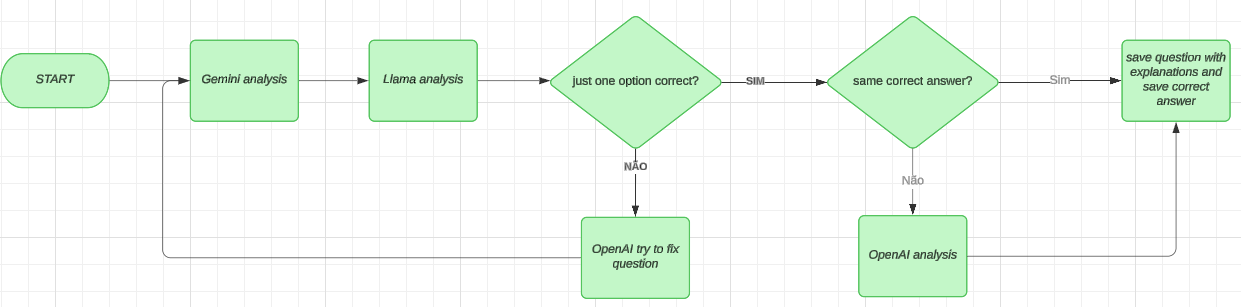

https://lucid.app/lucidchart/005f29d3-0274-4658-b470-e7e1cb8bc592/edit?viewport_loc=-283%2C-123%2C3415%2C1146%2C0_0&invitationId=inv_1b9160ba-6dae-4c95-b952-a272a699ca8e

In [6]:
from dotenv import load_dotenv
import json_repair
import json
import os
import pandas as pd

from pydantic import BaseModel, Field
from typing import Literal

from langgraph.graph import END, START, StateGraph, MessagesState
from typing_extensions import TypedDict
# from typing import Annotated
from IPython.display import Image, display


from supabase import create_client, Client

import os
from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env.

True

In [7]:
url: str = os.environ.get("SUPABASE_URL")
key: str = os.environ.get("SUPABASE_KEY")
supabase: Client = create_client(url, key)

In [8]:
df = pd.read_csv("questions.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 953 non-null    int64 
 1   created_at         953 non-null    object
 2   subject_matter     953 non-null    object
 3   topic_description  953 non-null    object
 4   level              953 non-null    object
 5   question           953 non-null    object
 6   type               953 non-null    object
 7   answer_correct     953 non-null    object
 8   explanation        953 non-null    object
 9   answer_a           953 non-null    object
 10  answer_b           953 non-null    object
 11  answer_c           953 non-null    object
 12  answer_d           953 non-null    object
dtypes: int64(1), object(12)
memory usage: 96.9+ KB


In [9]:
question = df.iloc[0]
question

id                                                                  11
created_at                               2024-09-22 12:31:43.546285+00
subject_matter                                             Probability
topic_description                       Understanding Confusion Matrix
level                                                     1 - Remember
question             Which term represents correctly classified pos...
type                                                  multiple_options
answer_correct                                                       a
explanation          True Positives (TP) represent the number of ca...
answer_a                                                True Positives
answer_b                                               False Positives
answer_c                                               False Negatives
answer_d                                                True Negatives
Name: 0, dtype: object

In [10]:
question["question"]

'Which term represents correctly classified positive cases?'

## Gemini

In [11]:
import google.generativeai as genai
from google.ai.generativelanguage_v1beta.types import content

key_gemini = os.environ["GOOGLE_API_KEY"]

genai.configure(api_key=key_gemini)

/workspaces/quiz_interview/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
schema = content.Schema(
    type=content.Type.OBJECT,
    properties={
        "option_a_explanation": content.Schema(
            type=content.Type.STRING,
            description="Detailed explanation of why the option 'a' is correct or not.",
        ),
        "option_b_explanation": content.Schema(
            type=content.Type.STRING,
            description="Detailed explanation of why the option 'b' is correct or not.",
        ),
        "option_c_explanation": content.Schema(
            type=content.Type.STRING,
            description="Detailed explanation of why the option 'c' is correct or not.",
        ),
        "option_d_explanation": content.Schema(
            type=content.Type.STRING,
            description="Detailed explanation of why the option 'd' is correct or not.",
        ),
        "just_one_option_correct": content.Schema(
            type=content.Type.BOOLEAN,
            description="If there is just one option correct.",
        ),
        "correct_answer": content.Schema(
            type=content.Type.STRING,
            description="The correct option. It could be 'a', 'b', 'c', 'd'.",
        ),
    },
    required=[
        "option_a_explanation",
        "option_b_explanation",
        "option_c_explanation",
        "option_d_explanation",
        "just_one_option_correct",
        "correct_answer",
    ]
)

In [13]:
# Create the model
generation_config = {
    "temperature": 0.5,
    "top_p": 0.95,
    # "top_k": 64,
    # "max_output_tokens": 8192,
    "response_schema": schema,
    "response_mime_type": "application/json",
}
    

llm_gemini = genai.GenerativeModel(
    # model_name="gemini-1.5-flash",
    model_name="gemini-1.5-flash-exp-0827",
    # model_name="gemini-1.5-pro-exp-0827",
    generation_config=generation_config,
    # safety_settings = Adjust safety settings
    # See https://ai.google.dev/gemini-api/docs/safety-settings
)

In [14]:
prompt_revision = (
    "# BACKGROUND INFORMATION OF YOUR ROLE:\n"
    "You are an expert in machine learning.\n"
    "You are verifying if a question from a bank of question is ok to be used in a job interview.\n"
    "your task is to analyse the provided question to verify if there is some problem.\n"
    "You shoud verify if there is just one option correct or if there is more than one.\n"
    "The question could be perfect fine, so you could say it too.\n"
    "Also, you should give a detailed explanation for your answer.\n"
    "# QUESTION\n\n"
    "{question}\n\n"
    "# Option a\n"
    "{option_a}\n\n"
    "# Option b\n"
    "{option_b}\n\n"
    "# Option c\n"
    "{option_c}\n\n"
    "# Option d\n"
    "{option_d}\n\n"
)

In [15]:
prompt_revision_formatted = prompt_revision.format(
        question=question["question"],
        option_a=question["answer_a"],
        option_b=question["answer_b"],
        option_c=question["answer_c"],
        option_d=question["answer_d"],        
    )

print( prompt_revision_formatted )

# BACKGROUND INFORMATION OF YOUR ROLE:
You are an expert in machine learning.
You are verifying if a question from a bank of question is ok to be used in a job interview.
your task is to analyse the provided question to verify if there is some problem.
You shoud verify if there is just one option correct or if there is more than one.
The question could be perfect fine, so you could say it too.
Also, you should give a detailed explanation for your answer.
# QUESTION

Which term represents correctly classified positive cases?

# Option a
True Positives

# Option b
False Positives

# Option c
False Negatives

# Option d
True Negatives




In [16]:
response = llm_gemini.generate_content(prompt_revision_formatted)
response

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "{\"correct_answer\": \"a\", \"just_one_option_correct\": true, \"option_a_explanation\": \"True Positives (TP) correctly identify positive cases. In a binary classification problem, where the goal is to predict whether something belongs to a certain class or not, a true positive is a case where the model correctly predicts that the instance belongs to the positive class.\", \"option_b_explanation\": \"False Positives (FP) incorrectly identify positive cases. They are also known as Type I errors. In a binary classification problem, a false positive is a case where the model incorrectly predicts that the instance belongs to the positive class when it actually belongs to the negative class.\", \"option_c_explanation\": \"False Negatives (FN) incorrectly identif

In [17]:
gemini_analysis = json_repair.loads(response.text)
gemini_analysis

{'correct_answer': 'a',
 'just_one_option_correct': True,
 'option_a_explanation': 'True Positives (TP) correctly identify positive cases. In a binary classification problem, where the goal is to predict whether something belongs to a certain class or not, a true positive is a case where the model correctly predicts that the instance belongs to the positive class.',
 'option_b_explanation': 'False Positives (FP) incorrectly identify positive cases. They are also known as Type I errors. In a binary classification problem, a false positive is a case where the model incorrectly predicts that the instance belongs to the positive class when it actually belongs to the negative class.',
 'option_c_explanation': 'False Negatives (FN) incorrectly identify negative cases. They are also known as Type II errors. In a binary classification problem, a false negative is a case where the model incorrectly predicts that the instance belongs to the negative class when it actually belongs to the positive

## Llama 3.1

In [18]:
class ExplanationSchema(BaseModel):
    option_a_explanation: str = Field(..., description="Detailed explanation of why the option 'a' is correct or not.")
    option_b_explanation: str = Field(..., description="Detailed explanation of why the option 'b' is correct or not.")
    option_c_explanation: str = Field(..., description="Detailed explanation of why the option 'c' is correct or not.")
    option_d_explanation: str = Field(..., description="Detailed explanation of why the option 'd' is correct or not.")
    just_one_option_correct: bool = Field(..., description="If there is just one option correct.")
    correct_answer: Literal['a', 'b', 'c', 'd'] = Field(..., description="The correct option. It could be 'a', 'b', 'c', or 'd'.")


In [19]:
from groq import Groq

key_groq = os.environ["GROQ_API_KEY"]
client = Groq(api_key=key_groq)

In [20]:
prompt_revision_with_json = prompt_revision + (
    "# OUTPUT FORMAT: json\n\n"
    "{output_format}"
)

In [21]:
prompt_revision_formatted = prompt_revision_with_json.format(
        question=question["question"],
        option_a=question["answer_a"],
        option_b=question["answer_b"],
        option_c=question["answer_c"],
        option_d=question["answer_d"],
        output_format=json.dumps(ExplanationSchema.model_json_schema(), indent=2)
    )

print( prompt_revision_formatted )

# BACKGROUND INFORMATION OF YOUR ROLE:
You are an expert in machine learning.
You are verifying if a question from a bank of question is ok to be used in a job interview.
your task is to analyse the provided question to verify if there is some problem.
You shoud verify if there is just one option correct or if there is more than one.
The question could be perfect fine, so you could say it too.
Also, you should give a detailed explanation for your answer.
# QUESTION

Which term represents correctly classified positive cases?

# Option a
True Positives

# Option b
False Positives

# Option c
False Negatives

# Option d
True Negatives

# OUTPUT FORMAT: json

{
  "properties": {
    "option_a_explanation": {
      "description": "Detailed explanation of why the option 'a' is correct or not.",
      "title": "Option A Explanation",
      "type": "string"
    },
    "option_b_explanation": {
      "description": "Detailed explanation of why the option 'b' is correct or not.",
      "title": 

In [22]:
response = client.chat.completions.create(
    # model="llama3-8b-8192",
    model="llama-3.1-70b-versatile",
    messages=[{
        "role": "user",
        "content": prompt_revision_formatted
    }],
    temperature=0.5,
    # max_tokens=2420,
    top_p=0.95,
    stream=False,
    response_format={"type": "json_object"},
    stop=None,
)

completion = response.choices[0].message
llama_analysis = json_repair.loads(completion.content)
llama_analysis

{'option_a_explanation': "Option 'a' is correct because True Positives (TP) refers to the number of positive cases that are correctly classified as positive. This term is used in the context of binary classification problems, where the goal is to distinguish between positive and negative cases. In this context, True Positives represent the correctly classified positive cases.",
 'option_b_explanation': "Option 'b' is incorrect because False Positives (FP) refers to the number of negative cases that are incorrectly classified as positive. This term is used in the context of binary classification problems, where the goal is to distinguish between positive and negative cases. In this context, False Positives represent the misclassified negative cases.",
 'option_c_explanation': "Option 'c' is incorrect because False Negatives (FN) refers to the number of positive cases that are incorrectly classified as negative. This term is used in the context of binary classification problems, where th

## OpenAI

In [23]:
from openai import OpenAI

client = OpenAI()

In [24]:
# prompt_merge = (
#     "# BACKGROUND INFORMATION OF YOUR ROLE:\n"
#     "You are an expert in machine learning.\n"
#     "You working (with some other professionals) verifying if a question from a bank of question is ok to be used in a job interview.\n"
#     "The question has already been analized by other professionals. Their analysis is below.\n"
#     "# YOUR TASK\n"
#     "your task is to give a detailed explanation for each option taken in consideration the analysis from the experts.\n"
#     "You should also take in consideration the choosen"
# )

## Avaliate question

In [25]:
prompt_revision_formatted = prompt_revision.format(
        question=question["question"],
        option_a=question["answer_a"],
        option_b=question["answer_b"],
        option_c=question["answer_c"],
        option_d=question["answer_d"],
        # output_format=json.dumps(ExplanationSchema.model_json_schema(), indent=2)
    )

print( prompt_revision_formatted )

# BACKGROUND INFORMATION OF YOUR ROLE:
You are an expert in machine learning.
You are verifying if a question from a bank of question is ok to be used in a job interview.
your task is to analyse the provided question to verify if there is some problem.
You shoud verify if there is just one option correct or if there is more than one.
The question could be perfect fine, so you could say it too.
Also, you should give a detailed explanation for your answer.
# QUESTION

Which term represents correctly classified positive cases?

# Option a
True Positives

# Option b
False Positives

# Option c
False Negatives

# Option d
True Negatives




In [26]:
completion = client.beta.chat.completions.parse(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": prompt_revision_formatted},
        # {"role": "user", "content": "hello"}
    ],
    response_format=ExplanationSchema,
)

In [27]:
completion.choices[0].message.parsed

ExplanationSchema(option_a_explanation='True Positives refer to the instances in a classification task where the model correctly predicts the positive class. These are the cases where the actual class is positive, and the model has correctly identified them as positive. Therefore, option a is the correct choice.', option_b_explanation='False Positives occur when the model incorrectly predicts a positive class for a case that is actually negative. This option does not represent correctly classified positive cases, so option b is incorrect.', option_c_explanation='False Negatives refer to the instances in a classification task where the model incorrectly predicts a negative class for a case that is actually positive. This option also does not represent correctly classified positive cases, so option c is incorrect.', option_d_explanation='True Negatives refer to the instances in which the model correctly predicts the negative class. This does not pertain to positive cases at all, so optio

In [28]:
type(completion.choices[0].message.parsed)

__main__.ExplanationSchema

In [29]:
completion.choices[0].message.parsed.option_a_explanation

'True Positives refer to the instances in a classification task where the model correctly predicts the positive class. These are the cases where the actual class is positive, and the model has correctly identified them as positive. Therefore, option a is the correct choice.'

In [30]:
analysis_openai = json_repair.loads( completion.choices[0].message.parsed.model_dump_json() )
analysis_openai

{'option_a_explanation': 'True Positives refer to the instances in a classification task where the model correctly predicts the positive class. These are the cases where the actual class is positive, and the model has correctly identified them as positive. Therefore, option a is the correct choice.',
 'option_b_explanation': 'False Positives occur when the model incorrectly predicts a positive class for a case that is actually negative. This option does not represent correctly classified positive cases, so option b is incorrect.',
 'option_c_explanation': 'False Negatives refer to the instances in a classification task where the model incorrectly predicts a negative class for a case that is actually positive. This option also does not represent correctly classified positive cases, so option c is incorrect.',
 'option_d_explanation': 'True Negatives refer to the instances in which the model correctly predicts the negative class. This does not pertain to positive cases at all, so option 

In [31]:
analysis_openai

{'option_a_explanation': 'True Positives refer to the instances in a classification task where the model correctly predicts the positive class. These are the cases where the actual class is positive, and the model has correctly identified them as positive. Therefore, option a is the correct choice.',
 'option_b_explanation': 'False Positives occur when the model incorrectly predicts a positive class for a case that is actually negative. This option does not represent correctly classified positive cases, so option b is incorrect.',
 'option_c_explanation': 'False Negatives refer to the instances in a classification task where the model incorrectly predicts a negative class for a case that is actually positive. This option also does not represent correctly classified positive cases, so option c is incorrect.',
 'option_d_explanation': 'True Negatives refer to the instances in which the model correctly predicts the negative class. This does not pertain to positive cases at all, so option 

### Try to fix question

In [32]:
prompt_fix_question = (
    "# BACKGROUND INFORMATION OF YOUR ROLE:\n"
    "You are an expert in machine learning.\n"
    "You working (with some other professionals) verifying if a question from a bank of question is ok to be used in a job interview.\n"
    "The question has already been analized by other professionals. Their analysis is below.\n"
    "It was already pointed that this question could have more than one option as correct, but it shouldn't. It should have just one correct option.\n"
    "# YOUR TASK\n"
    "your task is to fix the questions and/or the options in a way that it mantain the overall ideia for this question, but it should have after your correction, just one option as correct.\n"
    "Also, you should give a detailed explanation for your answer.\n\n"
    "# ORIGINAL QUESTION\n\n"
    "{question}\n\n"
    "# Option a\n"
    "{option_a}\n\n"
    "# Option b\n"
    "{option_b}\n\n"
    "# Option c\n"
    "{option_c}\n\n"
    "# Option d\n"
    "{option_d}\n\n"

    "# PROFESSIONAL ANALYSIS\n"
    "option_a_explanation\n"
    "{option_a_explanation}\n"
    "option_b_explanation\n"
    "{option_b_explanation}\n"
    "option_c_explanation\n"
    "{option_c_explanation}\n"
    "option_d_explanation\n"
    "{option_d_explanation}\n"
    
)

In [38]:
prompt_fix_question_formatted = prompt_fix_question.format(
        question=question["question"],
        option_a=question["answer_a"],
        # option_b=question["answer_b"],
        option_b="True Positives",
        option_c=question["answer_c"],
        option_d=question["answer_d"],
        
        option_a_explanation=gemini_analysis["option_a_explanation"],
        option_b_explanation=gemini_analysis["option_b_explanation"],
        option_c_explanation=gemini_analysis["option_c_explanation"],
        option_d_explanation=gemini_analysis["option_d_explanation"],
    )

print( prompt_fix_question_formatted )

# BACKGROUND INFORMATION OF YOUR ROLE:
You are an expert in machine learning.
You working (with some other professionals) verifying if a question from a bank of question is ok to be used in a job interview.
The question has already been analized by other professionals. Their analysis is below.
It was already pointed that this question could have more than one option as correct, but it shouldn't. It should have just one correct option.
# YOUR TASK
your task is to fix the questions and/or the options in a way that it mantain the overall ideia for this question, but it should have after your correction, just one option as correct.
Also, you should give a detailed explanation for your answer.

# ORIGINAL QUESTION

Which term represents correctly classified positive cases?

# Option a
True Positives

# Option b
True Positives

# Option c
False Negatives

# Option d
True Negatives

# PROFESSIONAL ANALYSIS
option_a_explanation
True Positives (TP) correctly identify positive cases. In a binary

In [39]:
class QuestionSchema(BaseModel):
    question: str = Field(..., description="The actual question text (fixed if necessary). It should be a question of type MULTIPLE OPTIONS. In this field you should put only the caput of the question, leaving the options to put in another field.")
    
    answer_a: str = Field(..., description="Option 'a' of answer for the current question (fixed if necessary).")
    answer_b: str = Field(..., description="Option 'b' of answer for the current question. (fixed if necessary)")
    answer_c: str = Field(..., description="Option 'c' of answer for the current question. (fixed if necessary)")
    answer_d: str = Field(..., description="Option 'd' of answer for the current question. (fixed if necessary)")

    option_a_explanation: str = Field(..., description="Detailed explanation of why the option 'a' is correct or not.")
    option_b_explanation: str = Field(..., description="Detailed explanation of why the option 'b' is correct or not.")
    option_c_explanation: str = Field(..., description="Detailed explanation of why the option 'c' is correct or not.")
    option_d_explanation: str = Field(..., description="Detailed explanation of why the option 'd' is correct or not.")
    
    correct_answer: Literal['a', 'b', 'c', 'd'] = Field(..., description="The correct option. It could be 'a', 'b', 'c', or 'd'.")
    
    just_one_option_correct: bool = Field(..., description="If there is just one option correct.")

    correction_explanation: str = Field(..., description="Describe the correction you did in this question.")

In [40]:
completion = client.beta.chat.completions.parse(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": prompt_fix_question_formatted},
        # {"role": "user", "content": "hello"}
    ],
    response_format=QuestionSchema,
)

In [42]:
openai_fix = json_repair.loads(completion.choices[0].message.parsed.model_dump_json())
openai_fix

{'question': 'Which term represents correctly classified positive cases?',
 'answer_a': 'True Positives',
 'answer_b': 'False Positives',
 'answer_c': 'False Negatives',
 'answer_d': 'True Negatives',
 'option_a_explanation': 'True Positives (TP) correctly identify positive cases. In a binary classification problem, where the goal is to predict whether something belongs to a certain class or not, a true positive is a case where the model correctly predicts that the instance belongs to the positive class.',
 'option_b_explanation': 'False Positives (FP) incorrectly identify positive cases. They are also known as Type I errors. In a binary classification problem, a false positive is a case where the model incorrectly predicts that the instance belongs to the positive class when it actually belongs to the negative class.',
 'option_c_explanation': 'False Negatives (FN) incorrectly identify negative cases. They are also known as Type II errors. In a binary classification problem, a false n

# Graph

In [70]:
class State(TypedDict):
    question_start: dict
    analysis_gemini: dict
    analysis_llama: dict
    analysis_openai: dict
    question_openai_fixed: dict
    already_tried_to_fix: bool = False

In [36]:
def chain_analysis_gemini(state: State):
    already_tried_to_fix = state["already_tried_to_fix"]

    if already_tried_to_fix:
        question = state["question_openai_fixed"]
    else:
        question = state["question_start"]


    prompt_revision_formatted = prompt_revision.format(
        question=question["question"],
        option_a=question["answer_a"],
        option_b=question["answer_b"],
        option_c=question["answer_c"],
        option_d=question["answer_d"],        
    )

    response = llm_gemini.generate_content(prompt_revision_formatted)
    analysis_gemini = json_repair.loads(response.text)
    
    return { "analysis_gemini": analysis_gemini }


In [37]:
def chain_analysis_llama(state: State):
    already_tried_to_fix = state["already_tried_to_fix"]

    if already_tried_to_fix:
        question = state["question_openai_fixed"]
    else:
        question = state["question_start"]

    prompt_revision_with_json = prompt_revision + (
        "# OUTPUT FORMAT: json\n\n"
        "{output_format}"
    )

    prompt_revision_formatted = prompt_revision_with_json.format(
        question=question["question"],
        option_a=question["answer_a"],
        option_b=question["answer_b"],
        option_c=question["answer_c"],
        option_d=question["answer_d"],
        output_format=json.dumps(ExplanationSchema.model_json_schema(), indent=2)
    )

    response = client.chat.completions.create(
        # model="llama3-8b-8192",
        model="llama-3.1-70b-versatile",
        messages=[{
            "role": "user",
            "content": prompt_revision_formatted
        }],
        temperature=0.5,
        # max_tokens=2420,
        top_p=0.95,
        stream=False,
        response_format={"type": "json_object"},
        stop=None,
    )

    completion = response.choices[0].message
    analysis_llama = json_repair.loads(completion.content)
    
    return { "analysis_llama": analysis_llama }

In [56]:
def chain_analysis_openai(state: State):
    question = state["question_start"]

    prompt_revision_formatted = prompt_revision.format(
        question=question["question"],
        option_a=question["answer_a"],
        option_b=question["answer_b"],
        option_c=question["answer_c"],
        option_d=question["answer_d"],
    )
    
    completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": prompt_revision_formatted},
            # {"role": "user", "content": "hello"}
        ],
        response_format=ExplanationSchema,
    )

    analysis_openai = json_repair.loads( completion.choices[0].message.parsed.model_dump_json() )

    return { "analysis_openai": analysis_openai }

In [55]:
def chain_try_fix_question(state: State):
    question = state["question_start"]

    prompt_fix_question_formatted = prompt_fix_question.format(
        question=question["question"],
        option_a=question["answer_a"],
        option_b=question["answer_b"],
        option_c=question["answer_c"],
        option_d=question["answer_d"],

        option_a_explanation=analysis_openai["option_a_explanation"],
        option_b_explanation=analysis_openai["option_b_explanation"],
        option_c_explanation=analysis_openai["option_c_explanation"],
        option_d_explanation=analysis_openai["option_d_explanation"],
    )

    completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": prompt_fix_question_formatted},
            # {"role": "user", "content": "hello"}
        ],
        response_format=ExplanationSchema,
    )

    question_openai_fixed = json_repair.loads(
        completion.choices[0].message.parsed.model_dump_json()
    )

    return {
        "question_openai_fixed": question_openai_fixed,
        "already_tried_to_fix": True
    }

In [72]:
def save_question(state: State):
    question_start = state["question_start"]
    analysis_gemini = state["analysis_gemini"]
    analysis_llama = state["analysis_llama"]
    analysis_openai = state["analysis_openai"]

    if analysis_openai:
        if analysis_openai["correct_answer"] == analysis_gemini["correct_answer"]:
            question = analysis_openai
        elif analysis_openai["correct_answer"] == analysis_llama["correct_answer"]:
            question = analysis_openai
        elif analysis_gemini["correct_answer"] == analysis_llama["correct_answer"]:
            question = analysis_gemini
        else:
            # if any of the LLMs agree, dont save this question
            return END
    else:
        question = analysis_gemini
    
    response = supabase.table('question').insert(
        {
            "subject_matter": question_start["subject_matter"],
            "topic_description": question_start["topic_description"],
            "level": question_start["level"],
            "question": question_start["question"],
            "type": question_start["type"],
            "answer_correct": question["answer_correct"],
            "answer_a": question_start["answer_a"],
            "answer_b": question_start["answer_b"],
            "answer_c": question_start["answer_c"],
            "answer_d": question_start["answer_d"],
            "explanation_a": question["explanation_a"],
            "explanation_b": question["explanation_b"],
            "explanation_c": question["explanation_c"],
            "explanation_d": question["explanation_d"],
        }).execute()

In [69]:
def verify_correct_answer_is_equal(state: State):
    analysis_gemini = state["analysis_gemini"]
    analysis_llama = state["analysis_llama"]
    already_tried_to_fix = state["already_tried_to_fix"]

    if analysis_gemini["correct_answer"] == analysis_llama['correct_answer']:
        if analysis_gemini["just_one_option_correct"] and analysis_llama['just_one_option_correct']:
            return "save_question"
        else:
            return "chain_analysis_openai"
    elif already_tried_to_fix:
        return END
    else:
        # i could try open ai analysis before try to fix
        return "chain_try_fix_question"


# def verify_correct_answer_is_equal(state: State):
#     analysis_gemini = state["analysis_gemini"]
#     analysis_llama = state["analysis_llama"]
#     already_tried_to_fix = state["already_tried_to_fix"]

#     if analysis_gemini["correct_answer"] == analysis_llama['correct_answer']:
#         if analysis_gemini["just_one_option_correct"] and analysis_llama['just_one_option_correct']:
#             return "save_question"
#         else:
#             return "chain_analysis_openai"
#     elif already_tried_to_fix:
#         return END
#     else:
#         return "chain_try_fix_question"

In [71]:
graph_builder = StateGraph(State)

graph_builder.add_node("chain_analysis_gemini", chain_analysis_gemini)
graph_builder.add_node("chain_analysis_llama", chain_analysis_llama)
graph_builder.add_node("chain_analysis_openai", chain_analysis_openai)
graph_builder.add_node("chain_try_fix_question", chain_try_fix_question)
graph_builder.add_node("save_question", save_question)

graph_builder.add_edge(START, "chain_analysis_gemini")
graph_builder.add_edge("chain_analysis_gemini", "chain_analysis_llama")
graph_builder.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "chain_analysis_llama",
    # Next, we pass in the function that will determine which node is called next.
    verify_correct_answer_is_equal,
)

graph_builder.add_edge("chain_analysis_openai", "save_question")
graph_builder.add_edge("chain_try_fix_question", "chain_analysis_gemini")
graph_builder.add_edge("save_question", END)

In [73]:
app = graph_builder.compile()

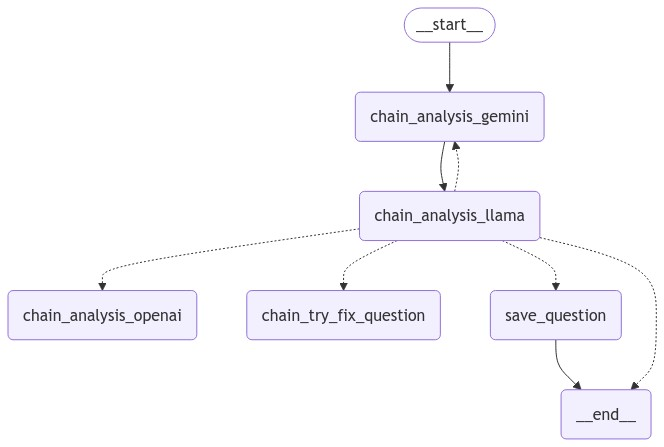

In [76]:
display(Image(app.get_graph().draw_mermaid_png()))